In [14]:
%run utils.py

<Figure size 432x288 with 0 Axes>

In [1]:
import cv2 as cv
import numpy as np

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

import pysight

###### Helpers

In [2]:
def crop_photo(frame, dim):
    """Helper function to crop a photo from given dimensions."""
    x,y,w,h = dim
    return frame[y:y+h, x:x+w]


def get_left_eye(eyes):
    """Helper function to get the left eye.
    Eyes: n * [x, y, w, h] for each eye detected in photo."""
    left_idx, left_val = -1, float('inf')
    
    for idx, val in enumerate(eyes):
        if val[0] < left_val:
            left_val = val[0]
            left_idx = idx
    
    return eyes[left_idx]

---

###### Objects

In [3]:
face_f = '../pysight/models/haarcascade_frontalface_alt.xml'
eyes_f = '../pysight/models/haarcascade_eye.xml'
dlib_f = '../pysight/models/shape_predictor_68_face_landmarks.dat'

webcam = pysight.Camera()
face_tools = pysight.FaceTools(face_f, eyes_f, dlib_f)
pupil_tools = pysight.pupil_tools.pupil_gradients.PupilGradients()
pose_tools = pysight.PoseTools()

##### Preprocessing

In [4]:
%ls -1 ../tests/test_imgs

eye-control.jpg
eye-crop-0.jpg
eye-double.jpg
eye-single.jpg
scrot2.png
scrot3.png
scrot.png
webcam-bad-eyes.jpg
webcam-bad-face.jpg
webcam-multiple.jpg
webcam-single-00.jpg
webcam-single-01.png


In [5]:
test_img = cv.imread('../tests/test_imgs/webcam-single-00.jpg') #00.jpg

print ("orig dim:\t{}".format(test_img.shape))

test_img_proc_scale = pysight.Camera().process(test_img, 2)
test_img_proc_nscale = pysight.Camera().process(test_img, 1)

print ("proc scale dim:\t{}".format(test_img_proc_scale.shape))
print ("proc NO scale dim:\t{}".format(test_img_proc_nscale.shape))

# Regular image
#cv2mpl(test_img, cv.COLOR_BGR2RGB) 

# Greyscale image
#cv2mpl(test_img_proc_scale, cv.COLOR_GRAY2RGB)

orig dim:	(872, 1360, 3)
proc scale dim:	(436, 680)
proc NO scale dim:	(872, 1360)


Test our face classifier

In [7]:
bb = face_tools.find_faces(test_img_proc_scale)
shape = face_tools.find_landmarks(test_img_proc_scale, bb)
cv_shape_pts = pose_tools.dlib_shape_2_cv(shape)

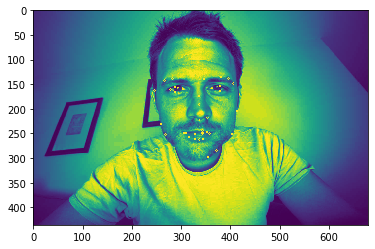

In [8]:
out_img = test_img_proc_scale.copy()
for p in cv_shape_pts:
    out_img = pysight.utils.drawing_utils.draw_circle(out_img, p[0], p[1], 2)
    
pysight.utils.drawing_utils.cv2mpl(out_img)

**Calculating Headpose**

Camera Matrix :
 [[1.28e+03 0.00e+00 6.40e+02]
 [0.00e+00 1.28e+03 3.60e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
Rotation Vector:
 [[-0.0489937 ]
 [ 2.17672626]
 [ 0.04098293]]
Translation Vector:
 [[  526.69704689]
 [  -50.69336713]
 [-2490.17560237]]


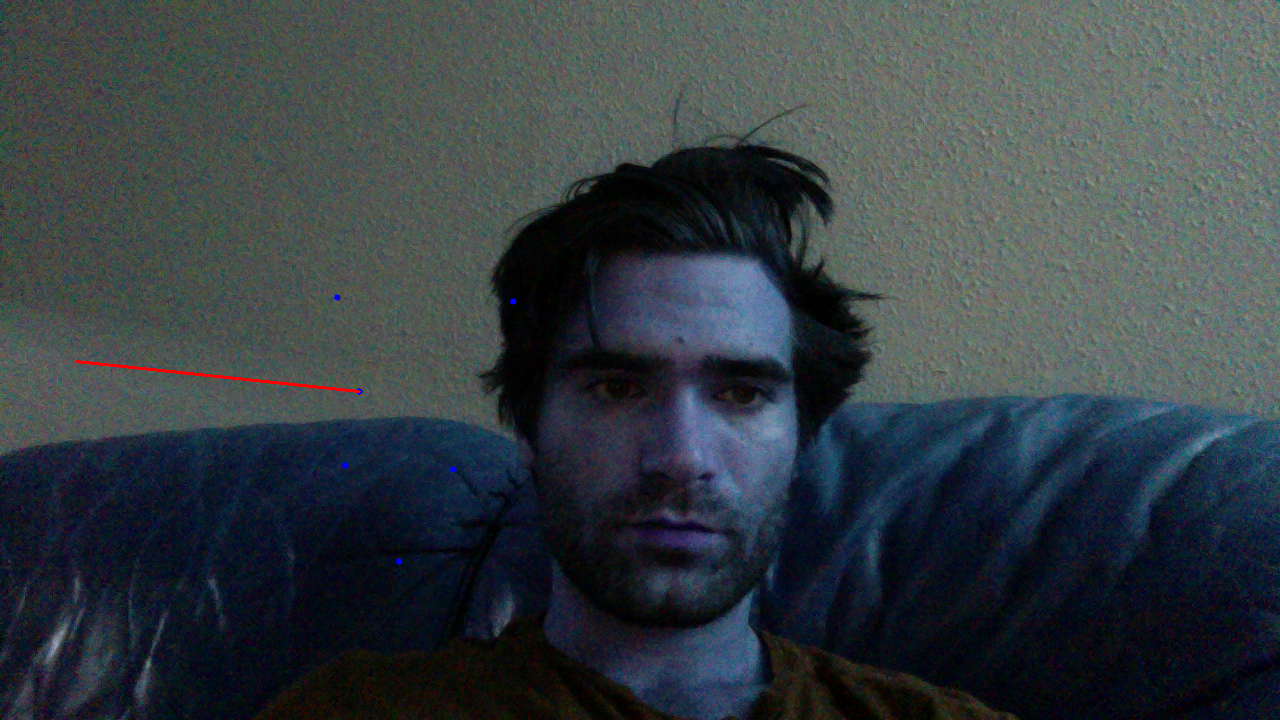

In [20]:
import cv2
import numpy as np
 
# Read Image
im = cv2.imread(img_paths[0])
size = im.shape
     
#2D image points. If you change the image, you need to change vector
image_points = np.array([
                            (359, 391),     # Nose tip
                            (399, 561),     # Chin
                            (337, 297),     # Left eye left corner
                            (513, 301),     # Right eye right corne
                            (345, 465),     # Left Mouth corner
                            (453, 469)      # Right mouth corner
                        ], dtype="double")
 
# 3D model points.
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner
                         
                        ])
 
 
# Camera internals
 
focal_length = size[1]
center = (size[1]/2, size[0]/2)
camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )
 
print("Camera Matrix :\n {}".format(camera_matrix))
 
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)
 
print("Rotation Vector:\n {0}".format(rotation_vector))
print("Translation Vector:\n {0}".format(translation_vector))
 
 
# Project a 3D point (0, 0, 1000.0) onto the image plane.
# We use this to draw a line sticking out of the nose
 
 
(nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
 
for p in image_points:
    cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,0,255), -1)
 
 
p1 = ( int(image_points[0][0]), int(image_points[0][1]))
p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
 
cv2.line(im, p1, p2, (255,0,0), 2)
showarray(im)